### Download data from GCS

In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
!gcloud config set project cnn-dailymail-387022

Updated property [core/project].


In [3]:
!gsutil cp gs://cnn-dailymail-data/validation.csv .

Copying gs://cnn-dailymail-data/validation.csv...
- [1 files][ 55.0 MiB/ 55.0 MiB]                                                
Operation completed over 1 objects/55.0 MiB.                                     


In [4]:
!gsutil cp gs://cnn-dailymail-predictions/first-300-chars.csv .
!gsutil cp gs://cnn-dailymail-predictions/hf-pretrained-bart-large-cnn.csv .
!gsutil cp gs://cnn-dailymail-predictions/hf-pretrained-pegasus-cnn_dailymail.csv .

Copying gs://cnn-dailymail-predictions/first-300-chars.csv...
/ [1 files][  4.4 MiB/  4.4 MiB]                                                
Operation completed over 1 objects/4.4 MiB.                                      
Copying gs://cnn-dailymail-predictions/hf-pretrained-bart-large-cnn.csv...
/ [1 files][  5.4 MiB/  5.4 MiB]                                                
Operation completed over 1 objects/5.4 MiB.                                      
Copying gs://cnn-dailymail-predictions/hf-pretrained-pegasus-cnn_dailymail.csv...
/ [1 files][  5.1 MiB/  5.1 MiB]                                                
Operation completed over 1 objects/5.1 MiB.                                      


In [5]:
!ls

first-300-chars.csv			 sample_data
hf-pretrained-bart-large-cnn.csv	 validation.csv
hf-pretrained-pegasus-cnn_dailymail.csv


### Post process for pegasus

In [7]:
import pandas as pd
prediction_df = pd.read_csv("hf-pretrained-pegasus-cnn_dailymail.csv")

In [9]:
def fix_pegasus(highlights):
  return highlights.replace("<n>", "\n")

prediction_df["prediction"] = prediction_df["prediction"].apply(fix_pegasus)

In [10]:
prediction_df.to_csv("hf-pretrained-pegasus-cnn_dailymail-fix-n.csv", index=False)

### Compute ROUGE scores

In [11]:
!pip install rouge-score
from rouge_score import rouge_scorer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=9a91a347caf1be3bcf1d37150e286692ded2a029621b51bb015c37dd974cb7b1
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [16]:
import pandas as pd
val_df = pd.read_csv("validation.csv")
prediction_df = pd.read_csv("hf-pretrained-pegasus-cnn_dailymail-fix-n.csv")
assert len(val_df) == len(prediction_df)

In [17]:
df = val_df.merge(prediction_df, on="id")
assert len(df) == len(val_df)

In [18]:
from tqdm import tqdm
tqdm.pandas()

scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"])

def compute_rouge(row):
  score = scorer.score(target=row["highlights"], prediction=row["prediction"])
  return score["rouge1"].fmeasure, score["rouge2"].fmeasure, score["rougeL"].fmeasure

df[["rouge1", "rouge2", "rougeL"]] = df.progress_apply(lambda row: compute_rouge(row), axis=1, result_type="expand")

100%|██████████| 13368/13368 [00:25<00:00, 519.34it/s]


In [19]:
import numpy as np

np.average(df["rouge1"]), np.average(df["rouge2"]), np.average(df["rougeL"])

(0.4369578543888382, 0.2169178501998561, 0.31212744222087874)

In [ ]:
df

,article,highlights,id,prediction,rouge1,rouge2,rougeL
0,"(CNN)Share, and your gift will be multiplied. ...",Zully Broussard decided to give a kidney to a ...,a4942dd663020ca54575471657a0af38d82897d6,A San Francisco woman donates one of her kidne...,0.236842,0.054054,0.157895
1,"(CNN)On the 6th of April 1996, San Jose Clash ...",The 20th MLS season begins this weekend .\nLea...,4157bc4da185971e2742f349d69a037343bc0d95,Major League Soccer kicks off its 20th season ...,0.246154,0.031746,0.184615
2,"(CNN)French striker Bafetimbi Gomis, who has a...",Bafetimbi Gomis collapses within 10 minutes of...,60736693e3b1b32d14337a317190c6606e879a85,"Bafetimbi Gomis says he is now ""feeling well"" ...",0.198198,0.055046,0.126126
3,(CNN)It was an act of frustration perhaps more...,Rory McIlroy throws club into water at WGC Cad...,8cdf9cc3ed0276b7a7944cc18ba459355b5984ad,Rory McIlroy hits 3-iron into lake during seco...,0.259259,0.115385,0.259259
4,(CNN)A Pennsylvania community is pulling toget...,"Cayman Naib, 13, hasn't been heard from since ...",2e6613d531843515bf5401286cc3e45c4df530d2,"Cayman Naib, 13, has been missing since Wednes...",0.285714,0.150000,0.285714
...,...,...,...,...,...,...,...
13363,"It is the dream of many young children, the ch...","The town in Valley Center, San Diego, has been...",5ab020397649fecae34c9e3ac2f7a6c67a5f3153,"The Wild West Town in Valley Center, San Diego...",0.571429,0.407767,0.495238
13364,It’s the type of encounter that can send panic...,Photographer Graham Hewer captured the jaw-dro...,b189166be7b1dc93f635d7860d4978498608ae07,Tourist Graham Hewer snapped the jaw-dropping ...,0.469565,0.230088,0.365217
13365,A group of tourists to the Bahamas enjoyed one...,The pigs swim through the crystal clear sea an...,c513500c9c53726b4ed0065b32bbca651c64b368,A group of tourists in the Bahamas were greete...,0.358491,0.076923,0.226415
13366,Pippa Middleton bundled up against the London ...,Kate's sister is back in London following 'cri...,cf2450f9e17d98ff9065c88262cba77855092d84,The Duchess of Cambridge's sister is back in L...,0.423529,0.240964,0.329412


### Write the examples to Google Drive

In [20]:
import gspread
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)

In [21]:
spreadsheet = gc.create("CNN Eval - Pretrained Pegasus (fix <n>)")

In [22]:
from gspread_dataframe import set_with_dataframe

worst_df = df.sort_values("rougeL").head(10)
worksheet1 = spreadsheet.add_worksheet(title="Worst 10", rows=100, cols=20)
set_with_dataframe(worksheet1, worst_df)

In [23]:
best_df = df.sort_values("rougeL", ascending=False).head(10)
worksheet1 = spreadsheet.add_worksheet(title="Best 10", rows=100, cols=20)
set_with_dataframe(worksheet1, best_df)

### Plot the distribution of the scores

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='rougeL', ylabel='Count'>

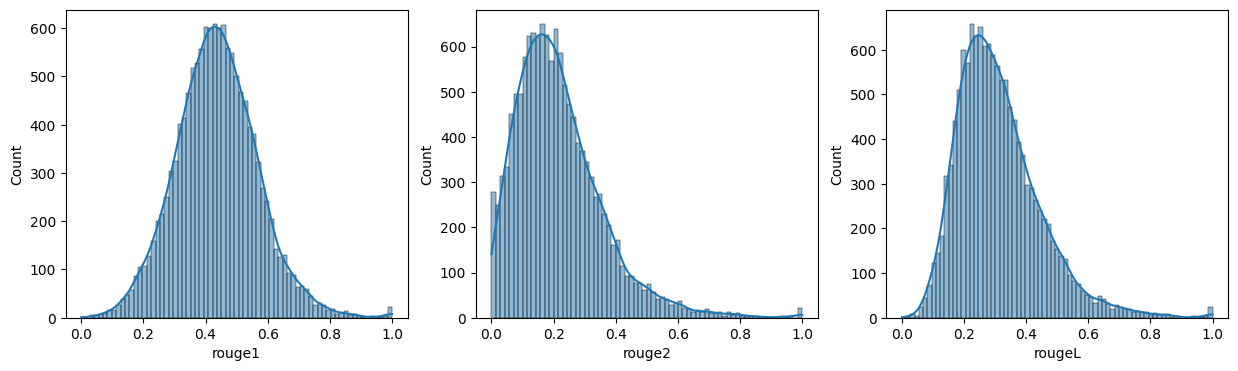

In [34]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

sns.histplot(df["rouge1"], kde=True, ax=axs[0])
sns.histplot(df["rouge2"], kde=True, ax=axs[1])
sns.histplot(df["rougeL"], kde=True, ax=axs[2])